### Латыпов Ильяс Дамирович (MADE DS-22, Latypovid@yandex.ru)
### Лабораторная работа по Deep Learning

In [1]:
import numpy as np
import pandas as pd
import os

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics import CharErrorRate

import torchvision
import torchvision.transforms as transforms

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

from skimage import io
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style("ticks")
sns.set_context("poster", font_scale = 1, rc={"grid.linewidth": 2})
%matplotlib inline

In [2]:
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Current device {DEVICE}')

Current device cuda


In [3]:
SEED = 999
torch.manual_seed(SEED)

BATCH_SIZE = 64
TEST_SIZE = 0.2

DATASET_PATH = r"samples_2v/"
EXT = "png"

In [4]:
r4 = lambda x: round(x, 4)

### Формирование Датасета

In [5]:
# ClassificationDataset
class ClassificationDataset(Dataset):
    def __init__(self, paths, targets):
        self.paths = paths
        self.targets = targets
        self.data_prepare = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img_name = self.paths[idx]
        target = torch.tensor(self.targets[idx], dtype=torch.float)
        image = self.data_prepare(io.imread(img_name))
        return image, target

In [6]:
# подгтовка таргетов
paths = []
paths_labels = []
labels = []
for file_name in os.listdir(DATASET_PATH):
    if file_name.split('.')[-1] == EXT:
        paths.append(DATASET_PATH + file_name)
        label = file_name.split('.')[0]
        labels.append(label)
        paths_labels.append([DATASET_PATH + file_name, label])

print(paths[:5])
print(labels[:5])
print("Кол-во меток", len(paths_labels))

['samples_2v/226md.png', 'samples_2v/22d5n.png', 'samples_2v/2356g.png', 'samples_2v/23mdg.png', 'samples_2v/23n88.png']
['226md', '22d5n', '2356g', '23mdg', '23n88']
Кол-во меток 1040


In [7]:
labels_arr = [list(i) for i in labels]
print(labels_arr[:3])

[['2', '2', '6', 'm', 'd'], ['2', '2', 'd', '5', 'n'], ['2', '3', '5', '6', 'g']]


In [8]:
labels_arr_flatten = [j for i in labels_arr for j in i ]
print(labels_arr_flatten[:15])

['2', '2', '6', 'm', 'd', '2', '2', 'd', '5', 'n', '2', '3', '5', '6', 'g']


In [9]:
# кодировка символов
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(labels_arr_flatten)
targets = np.array([label_encoder.transform(x) for x in labels_arr])

In [10]:
# подготовка загрузчиков данных
train_data, test_data, train_targets, test_targets = train_test_split(paths, targets, test_size=TEST_SIZE, random_state=SEED)
train_dataset = ClassificationDataset(train_data, train_targets)
test_dataset = ClassificationDataset(test_data, test_targets)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### Моделирование (обучение)

In [11]:
class CaptchaModel(nn.Module):
    def __init__(self):
        super(CaptchaModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2)),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.Dropout(p=0.2),

            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            nn.BatchNorm2d(64),
            nn.Dropout(p=0.2)
        )

        self.linear_1 = nn.Linear(832, 128)
        self.lstm = nn.LSTM(128, 32, bidirectional=True, batch_first=True)
        self.linear_2 = nn.Linear(64, 20)

    def forward(self, x, targets):
        bs, _, _, _ = x.size()
        x = self.conv_layers(x)
        x = x.permute(0, 3, 1, 2)
        x = x.view(bs, x.size(1), -1)
        x = self.linear_1(x)
        x = nn.functional.relu(x)
        x, h = self.lstm(x)
        x = self.linear_2(x)
        x = x.permute(1, 0, 2)
        loss = None
        if targets is not None:
            log_probs = nn.functional.log_softmax(x, 2)
            input_lengths = torch.full(size=(bs,), fill_value=log_probs.size(0), dtype=torch.int32)
            target_lengths = torch.full(size=(bs,), fill_value=targets.size(1), dtype=torch.int32)
            loss = nn.CTCLoss(blank=19)(log_probs, targets, input_lengths, target_lengths)

        return x, loss

In [12]:
def train(model, optimizer, train_loader, test_loader, encoder, num_epochs):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):

        # train
        model.train()
        sum_loss = 0
        for images, targets in train_loader:
            optimizer.zero_grad()
            targets = targets.to(DEVICE)
            images = images.to(DEVICE)              
            train_pred, loss = model(images, targets)
            loss.requres_grad = True
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()
            loss.detach()

        train_loss = sum_loss / len(train_loader)          
        train_losses.append(train_loss)         

        # validation eval                     
        model.eval()
        sum_loss = 0
        with torch.no_grad():
            for images, targets in test_loader:
                images = images.to(DEVICE)
                targets = targets.to(DEVICE)
                val_pred, loss = model(images, targets)
                loss.requres_grad = True
                sum_loss += loss.item()

        val_loss = sum_loss / len(test_loader)
        val_losses.append(val_loss)

        if (epoch + 1) % 10 == 0:
            print(f"Epoch: {epoch + 1}, train loss: {r4(train_loss)},  val. loss: {r4(val_loss)}")

    return train_losses, val_losses

In [13]:
%%time
model = CaptchaModel()
model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=2E-3)
num_epochs = 90

train_loss, val_loss = train(model, optimizer, train_loader, test_loader, label_encoder, num_epochs)

Epoch: 10, train loss: 3.2558,  val. loss: 3.2888
Epoch: 20, train loss: 3.2352,  val. loss: 3.2689
Epoch: 30, train loss: 2.4145,  val. loss: 2.2787
Epoch: 40, train loss: 0.2438,  val. loss: 0.2393
Epoch: 50, train loss: 0.0677,  val. loss: 0.0795
Epoch: 60, train loss: 0.032,  val. loss: 0.0542
Epoch: 70, train loss: 0.0184,  val. loss: 0.0619
Epoch: 80, train loss: 0.0098,  val. loss: 0.0402
Epoch: 90, train loss: 0.0086,  val. loss: 0.0392
Wall time: 1min 37s


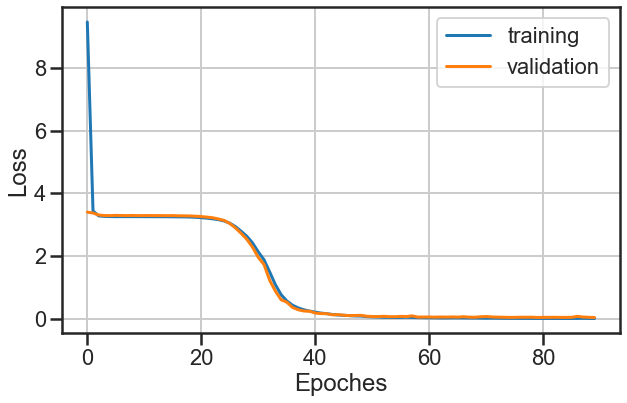

In [14]:
def plot_losses(train_loss, val_loss):
    plt.figure(figsize=(10, 6))
    plt.plot(train_loss, label = 'training')
    plt.plot(val_loss, label = 'validation')
    plt.grid()
    plt.xlabel('Epoches')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
plot_losses(train_loss, val_loss)

### Оценка CharErrorRate

In [15]:
def decode(batch_outputs, encoder):
    predictions_labels = []
    for j in range(batch_outputs.shape[1]):
        model_output = batch_outputs[:, j, :].unsqueeze(1)
        
        model_output_permuted = model_output.permute(1, 0, 2)
        model_output_converted_to_probabilities = torch.softmax(model_output_permuted, 2)
        model_output_BPA_applied_gpu = torch.argmax(model_output_converted_to_probabilities, 2)
        model_output_BPA_applied = model_output_BPA_applied_gpu.detach().cpu().numpy().squeeze()

        prediction_ctc = []
        for n in model_output_BPA_applied:
            if n == 19:
                prediction_ctc.append("_")
            else:
                c = encoder.inverse_transform([n])[0]
                prediction_ctc.append(c)

        model_ouput_without_dublicates = []
        for i in range(len(prediction_ctc)):
            if i == 0:
                model_ouput_without_dublicates.append(prediction_ctc[i])
            else:
                if model_ouput_without_dublicates[-1] != prediction_ctc[i]:
                    model_ouput_without_dublicates.append(prediction_ctc[i])

        model_ouput_without_blanks = []
        for e in model_ouput_without_dublicates:
            if e != "_":
                model_ouput_without_blanks.append(e)
        prediction_label = "".join(model_ouput_without_blanks)
        predictions_labels.append(prediction_label)

    return predictions_labels

In [16]:
def evaluations(model, test_loader, encoder):
    model.eval()
    cer_loss = CharErrorRate()
    predictions = []
    pred_labels = []    
    test_labels = []
    test_img = []
    
    with torch.no_grad():
        for images, targets in test_loader:
            images = images.to(DEVICE)
            targets = targets.to(DEVICE)
            test_pred, loss = model(images, targets)
            predictions.append(test_pred.detach())

    for pred in predictions:
        pred_labels.extend(decode(pred, encoder))

    for images, labels in test_loader:
        for ind, label in enumerate(labels):
            label = label.type(torch.int).tolist()
            test_labels.append(''.join(encoder.inverse_transform(label)))
            test_img.append(images[ind].squeeze())
      
    test_cer_loss = cer_loss(pred_labels, test_labels).item()        
    test_result_summary = []
    for ind in range(len(test_labels)):
        img = test_img[ind]
        summary = dict()
        summary["data"] = img
        summary["char_err"] = cer_loss(pred_labels[ind], test_labels[ind]).item()
        summary["label"] = test_labels[ind]
        summary["prediction"] = pred_labels[ind]
        test_result_summary.append(summary)

    return test_cer_loss, test_result_summary

In [17]:
test_cer_loss, test_result_summary = evaluations(model, test_loader, label_encoder)
print(f"CharErrorRate: {test_cer_loss}")

CharErrorRate: 0.010576923377811909


### Представление рисунков с наибольшей ошибкой

        Label: wgnwp
   Prediction: wgmmwp
CharErrorRate: 0.4


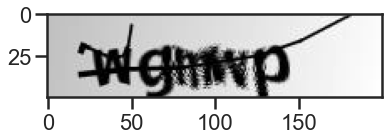

        Label: bwmee
   Prediction: bwnee
CharErrorRate: 0.2


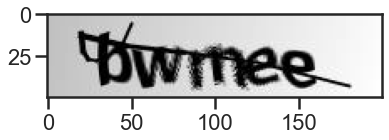

        Label: pw5nc
   Prediction: pw5c
CharErrorRate: 0.2


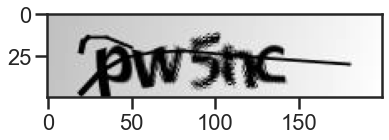

        Label: nmw46
   Prediction: nmmw46
CharErrorRate: 0.2


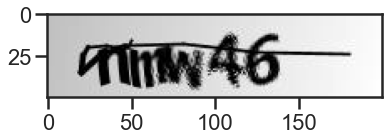

        Label: mxnw4
   Prediction: mxmw4
CharErrorRate: 0.2


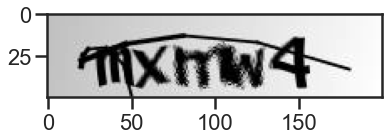

In [18]:
quantity = 5
test_result_summary = sorted(test_result_summary, key=lambda x: x["char_err"], reverse=True)
for img in test_result_summary[:quantity]:
    print(f"        Label: {img['label']}\n   Prediction: {img['prediction']}")
    print(f"CharErrorRate: {r4(img['char_err'])}")
    plt.imshow(img["data"], cmap="gray")
    plt.show()

### Анализ и выводы

 - Получено хорошее качество метрики CharErrorRate - 0.01
 - Структура нейросети CNN+Bi-LSTM оказалась подходящей для распозования карnинок последовательных зашумленных символов
 - Ошибки распознования символов возникают: 
    - при наложении символов (даже человеку бывает сложно визуально понять правильный ответ), например часто "n" превращается в "m" за счет части следующего символа
    - либо когда символ вообще не распознается (слишком зашумленный)